In [1]:
import os
import warnings
import re
warnings.filterwarnings("ignore")

from tqdm.notebook import tqdm

import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np
import math
import pandas as pd
import sklearn
import scipy as sc

import rpy2.rinterface
%load_ext rpy2.ipython

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.feature_selection import mutual_info_classif, f_classif, VarianceThreshold, SelectKBest

import xgboost as xgb

from IPython.display import display

## Setting some parameters, loading data

In [35]:
# Setting up the directory with the data
_DATA_FOLDER = 'lncRNA_affy_data_new'

# Reading the data
raw_df = pd.read_csv(f'{_DATA_FOLDER}/dataBalanced.csv')
gene_scores = pd.read_csv(f'{_DATA_FOLDER}/selected_variables.csv')

# Separating features and target
df = raw_df.iloc[:, :-1]
target = raw_df.iloc[:, -1]

# Saving the labels
labels = target.unique()

# Having a pick at the data
print('Input data:')
display(raw_df.head())
print()

# Showing how many classes the data has
print('Class distribution:')
display(raw_df['Label'].value_counts())
print()

# Having a pick at the gene scores
print('Gene scores:')
gene_scores.head()

Input data:


,A1BG-AS1,A2M-AS1,AA06,ACTA2-AS1,ACVR2B-AS1,ADAMTS9-AS2,ADARB2-AS1,ADD3-AS1,ADIRF-AS1,ADORA2A-AS1,...,ZNF32-AS3,ZNF503-AS1,ZNF503-AS2,ZNF571-AS1,ZNF667-AS1,ZNF674-AS1,ZNF790-AS1,ZRANB2-AS1,ZSCAN16-AS1,Label
0,0.986777,0.918804,1.022330,0.942865,1.056324,5.583921,1.022020,3.071460,0.977870,2.246206,...,2.048482,1.213379,4.137023,1.047637,0.988586,1.035950,2.094243,1.021524,2.982927,C
1,0.964514,0.965923,0.979102,0.971376,0.983233,4.984950,1.028229,3.113540,0.994136,1.939292,...,1.897929,0.999018,3.758432,0.943754,1.009126,1.030797,1.837639,0.980782,3.017070,C
2,1.040910,1.095108,1.028325,0.943246,1.017799,5.362886,0.965249,2.985929,1.073442,1.973732,...,2.126883,0.834130,3.754209,1.028730,1.173873,0.920503,2.044482,0.992441,3.021430,C
3,0.975662,0.971483,1.023094,1.005302,1.021771,4.489597,0.993367,3.159738,0.963009,1.927878,...,1.759135,0.991861,4.117718,0.927741,1.062716,1.057921,1.915265,1.011904,3.132396,C
4,0.990206,0.996527,0.961097,0.850262,0.969824,5.467835,1.043923,3.098369,0.938168,2.134826,...,2.190440,1.029302,3.957010,1.054379,0.990264,0.954192,1.722314,1.019540,3.148515,C



Class distribution:


H48       511
C         511
H0        511
H24       511
PS_H24    511
Name: Label, dtype: int64


Gene scores:


,feature,score
0,ACTA2-AS1,1.0
1,ADIRF-AS1,1.0
2,ALDH1L1-AS2,1.0
3,ALMS1-IT1,1.0
4,ARHGAP5-AS1,1.0


## Exploratory data analysis

First we should look at the data distribution of the gene expression.

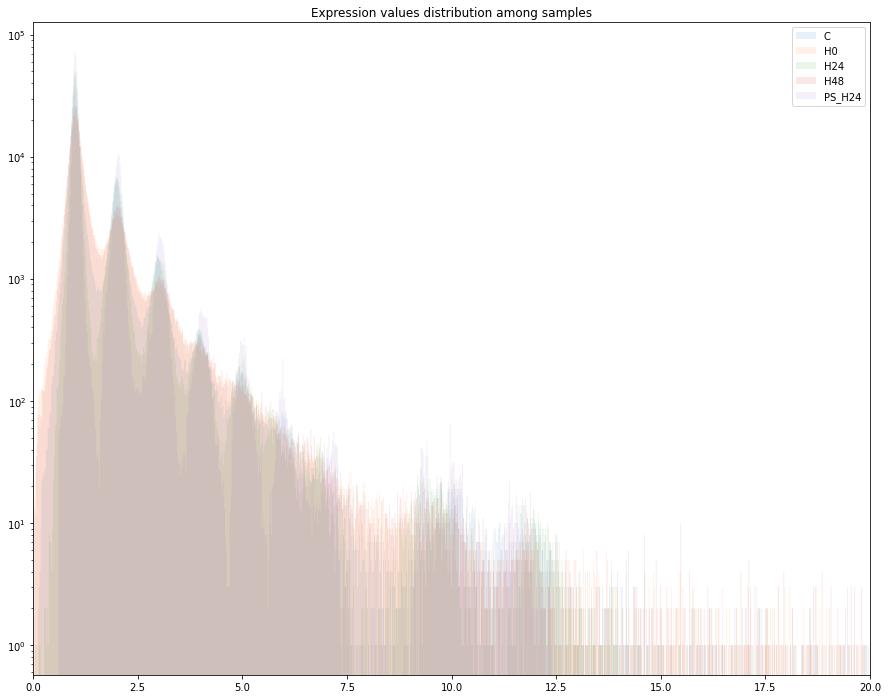

In [39]:
f, ax = plt.subplots(figsize=(15, 12))

for label in labels:
    vals = df.loc[target[target == label].index].values.reshape(-1)
    plt.hist(vals, label=label, alpha=0.1, bins='auto', histtype='stepfilled')
    
plt.yscale('log')
plt.xlim([0, 20])
plt.legend()
plt.title('Expression values distribution among samples');

We can observe that gene expression values are well mixed between classes and thus there seems to be no *batch effect*. 

Let us pick only the genes that have sufficient variation in the data.

In [43]:
# Selecting the variance threshold (genes with lesser or equal variance will be removed)
_VAR_THRESH = 0.05

# Fitting the object
var_sel = VarianceThreshold(_VAR_THRESH).fit(df)

# Creating updated version of df
new_df = pd.DataFrame(var_sel.transform(df), index=df.index, columns=df.columns[var_sel.get_support(indices=True)])

print(f'After filtering out genes with less or equal than {_VAR_THRESH * 100:.1f} % of variance the number of genes changed: {df.shape[1]} -> {new_df.shape[1]}..')

After filtering out genes with less or equal than 5.0 % of variance the number of genes changed: 1084 -> 321..


## Machine Learning
### Preparing data

Now we are ready for the ML pipeline. Here we have a multi-class problem, and thus we will use the appropriate tools. [Here](https://scikit-learn.org/stable/modules/multiclass.html) you can find a nice description of all available algorithms..

In [46]:
# Setting some hyperparams
_DATA_SIZE = len(new_df)
_TRAIN_PERCENTAGE = 0.9
_TEST_PERCENTAGE = 1 - _TRAIN_PERCENTAGE
_TRAIN_SIZE = int(_TRAIN_PERCENTAGE * _DATA_SIZE)
_TEST_SIZE = int(_TEST_PERCENTAGE * _DATA_SIZE)
_SEED = 42

# Scaling features
scaler = StandardScaler()
scaler.fit(new_df.iloc[:_TRAIN_SIZE, :])
data = scaler.transform(new_df)
data_df = pd.DataFrame(data, index=new_df.index, columns=new_df.columns)

# Splitting the data into train and test, scaling the data
X_train, X_test, y_train, y_test = train_test_split(data, target, 
                                                    test_size=_TEST_PERCENTAGE,
                                                    random_state=_SEED)

accuracy_metrics = {}
f1_score_metrics = {}

print(f'The size of the train set: {X_train.shape}')
print(f'The size of the test set: {X_test.shape}')

The size of the train set: (2299, 321)
The size of the test set: (256, 321)


### Logistic regression

Now we are ready to train a simple logistic regression. Here as it is multi-class problem the output of the model will be `multinomial`, which means that it does predict multiple classes.

In [65]:
# Training logistic regression
log_reg = LogisticRegression(multi_class='multinomial', random_state=_SEED).fit(X_train, y_train)

# Computing predictions and evaluating the model
y_train_pred = log_reg.predict(X_train)
y_test_pred = log_reg.predict(X_test)

accuracy_metrics['Logistic Regression'] = accuracy_score(y_test, y_test_pred)
f1_score_metrics['Logistic Regression'] = f1_score(y_test, y_test_pred, average='macro')

print('LOGISTIC REGRESSION')
print('Train:')
print(classification_report(y_train, y_train_pred))
print('\nTest:')
print(classification_report(y_test, y_test_pred))

LOGISTIC REGRESSION
Train:
              precision    recall  f1-score   support

           C       1.00      1.00      1.00       459
          H0       1.00      1.00      1.00       467
         H24       1.00      1.00      1.00       450
         H48       1.00      1.00      1.00       460
      PS_H24       1.00      1.00      1.00       463

    accuracy                           1.00      2299
   macro avg       1.00      1.00      1.00      2299
weighted avg       1.00      1.00      1.00      2299


Test:
              precision    recall  f1-score   support

           C       0.98      1.00      0.99        52
          H0       0.95      0.84      0.89        44
         H24       0.94      1.00      0.97        61
         H48       0.94      0.94      0.94        51
      PS_H24       1.00      1.00      1.00        48

    accuracy                           0.96       256
   macro avg       0.96      0.96      0.96       256
weighted avg       0.96      0.96      0.96

We have succeeded, and the model seems to capture the differences in groups and achieves good accuracy! Now let us print the most predictive lncRNAs (with highest/lowest coefficients)..

In [67]:
lowest_5, highest_5 = data_df.columns[np.argsort(log_reg.coef_[0])[:5]], \
    data_df.columns[np.argsort(log_reg.coef_[0])[-5:]]

print('Top lncRNAs in terms of predictive power:')
print(f'Highest coefficients -> {", ".join(highest_5)}')
print(f'Lowest coefficients -> {", ".join(lowest_5)}')

Top lncRNAs in terms of predictive power:
Highest coefficients -> MCHR2-AS1, PHF1, MDS2, LINC00877, CABIN1
Lowest coefficients -> RAMP2-AS1, WDFY3-AS2, BCRP3, LINC01186, LINC01352


### SVM

Next we will use SVM with RBF kernel. Here we cannot use `multinomial`, by default the only implemented version of SVM for multi-class problems is OvO or One-vs-One technique. 

In [69]:
# Training decision trees
rbf_svm = SVC(random_state=_SEED).fit(X_train, y_train)

# Computing predictions and evaluating the model
y_train_pred = rbf_svm.predict(X_train)
y_test_pred = rbf_svm.predict(X_test)

accuracy_metrics['SVM'] = accuracy_score(y_test, y_test_pred)
f1_score_metrics['SVM'] = f1_score(y_test, y_test_pred, average='macro')

print('LOGISTIC REGRESSION')
print('Train:')
print(classification_report(y_train, y_train_pred))
print('\nTest:')
print(classification_report(y_test, y_test_pred))

LOGISTIC REGRESSION
Train:
              precision    recall  f1-score   support

           C       0.99      1.00      1.00       459
          H0       1.00      0.93      0.96       467
         H24       0.86      1.00      0.93       450
         H48       1.00      0.90      0.94       460
      PS_H24       1.00      1.00      1.00       463

    accuracy                           0.97      2299
   macro avg       0.97      0.97      0.97      2299
weighted avg       0.97      0.97      0.97      2299


Test:
              precision    recall  f1-score   support

           C       0.96      1.00      0.98        52
          H0       0.91      0.89      0.90        44
         H24       0.86      1.00      0.92        61
         H48       0.97      0.76      0.86        51
      PS_H24       1.00      1.00      1.00        48

    accuracy                           0.93       256
   macro avg       0.94      0.93      0.93       256
weighted avg       0.94      0.93      0.93

### Decision tree

Decision trees are inherently multi-class.

In [72]:
# Training decision trees
dec_tree = DecisionTreeClassifier(random_state=_SEED).fit(X_train, y_train)

# Computing predictions and evaluating the model
y_train_pred = dec_tree.predict(X_train)
y_test_pred = dec_tree.predict(X_test)

accuracy_metrics['Decision Tree'] = accuracy_score(y_test, y_test_pred)
f1_score_metrics['Decision Tree'] = f1_score(y_test, y_test_pred, average='macro')

print('LOGISTIC REGRESSION')
print('Train:')
print(classification_report(y_train, y_train_pred))
print('\nTest:')
print(classification_report(y_test, y_test_pred))

LOGISTIC REGRESSION
Train:
              precision    recall  f1-score   support

           C       1.00      1.00      1.00       459
          H0       1.00      1.00      1.00       467
         H24       1.00      1.00      1.00       450
         H48       1.00      1.00      1.00       460
      PS_H24       1.00      1.00      1.00       463

    accuracy                           1.00      2299
   macro avg       1.00      1.00      1.00      2299
weighted avg       1.00      1.00      1.00      2299


Test:
              precision    recall  f1-score   support

           C       1.00      0.98      0.99        52
          H0       0.80      0.75      0.78        44
         H24       0.94      0.95      0.94        61
         H48       0.76      0.80      0.78        51
      PS_H24       0.98      0.98      0.98        48

    accuracy                           0.90       256
   macro avg       0.90      0.89      0.89       256
weighted avg       0.90      0.90      0.90

Let us have a look at the most important features using Gini importance score.

In [73]:
gini_important_features = data_df.columns[np.argsort(dec_tree.feature_importances_)[-10:]]
print('Top 5 lncRNAs in terms of predictive power:')
print(f'{", ".join(gini_important_features)}')

Top 5 lncRNAs in terms of predictive power:
LINC00954, HLA-F-AS1, LINC01089, CABIN1, LINC00884, LINC01093, ADIRF-AS1, PP7080, CYB561D2, LINC00266-1


### Gradient boosting (XGBoost)

XGBoost could be also tuned for multi-class problem using `objective=multi:softmax` parameter.

In [76]:
# Training xgboost model
xgb_model = xgb.XGBClassifier(objective="multi:softmax", random_state=_SEED)
xgb_model.fit(X_train, y_train)

# Computing predictions and evaluating the model
y_train_pred = xgb_model.predict(X_train)
y_test_pred = xgb_model.predict(X_test)

accuracy_metrics['XGBoost'] = accuracy_score(y_test, y_test_pred)
f1_score_metrics['XGBoost'] = f1_score(y_test, y_test_pred, average='macro')

print('GRADIENT BOOSTING')
print('Train:')
print(classification_report(y_train, y_train_pred))
print('\nTest:')
print(classification_report(y_test, y_test_pred))

[08:34:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
GRADIENT BOOSTING
Train:
              precision    recall  f1-score   support

           C       1.00      1.00      1.00       459
          H0       1.00      1.00      1.00       467
         H24       1.00      1.00      1.00       450
         H48       1.00      1.00      1.00       460
      PS_H24       1.00      1.00      1.00       463

    accuracy                           1.00      2299
   macro avg       1.00      1.00      1.00      2299
weighted avg       1.00      1.00      1.00      2299


Test:
              precision    recall  f1-score   support

           C       1.00      1.00      1.00        52
          H0       0.95      0.95      0.95        44
         H24       1.00      1.00      1.00        61
         

Getting out the same way feature importances..

In [77]:
xgboost_important_features = data_df.columns[np.argsort(xgb_model.feature_importances_)[-10:]]
print('Top 5 lncRNAs in terms of predictive power:')
print(f'{", ".join(xgboost_important_features)}')

Top 5 lncRNAs in terms of predictive power:
CHRM3-AS2, MAPT-AS1, LINC01013, LEF1-AS1, XIST, GRTP1-AS1, LINC00623, LINC00954, LINC00528, WDFY3-AS2


### Random Forest

Random forest is also inherently multiclass..

In [78]:
# Training decision trees
rf = RandomForestClassifier(random_state=_SEED).fit(X_train, y_train)

# Computing predictions and evaluating the model
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

accuracy_metrics['Random Forest'] = accuracy_score(y_test, y_test_pred)
f1_score_metrics['Random Forest'] = f1_score(y_test, y_test_pred, average='macro')

print('LOGISTIC REGRESSION')
print('Train:')
print(classification_report(y_train, y_train_pred))
print('\nTest:')
print(classification_report(y_test, y_test_pred))

LOGISTIC REGRESSION
Train:
              precision    recall  f1-score   support

           C       1.00      1.00      1.00       459
          H0       1.00      1.00      1.00       467
         H24       1.00      1.00      1.00       450
         H48       1.00      1.00      1.00       460
      PS_H24       1.00      1.00      1.00       463

    accuracy                           1.00      2299
   macro avg       1.00      1.00      1.00      2299
weighted avg       1.00      1.00      1.00      2299


Test:
              precision    recall  f1-score   support

           C       0.96      1.00      0.98        52
          H0       0.91      0.95      0.93        44
         H24       0.94      1.00      0.97        61
         H48       1.00      0.84      0.91        51
      PS_H24       1.00      1.00      1.00        48

    accuracy                           0.96       256
   macro avg       0.96      0.96      0.96       256
weighted avg       0.96      0.96      0.96

Let us again have a look at the most important features using Gini importance score.

In [79]:
gini_important_features = data_df.columns[np.argsort(rf.feature_importances_)[-10:]]
print('Top 5 lncRNAs in terms of predictive power:')
print(f'{", ".join(gini_important_features)}')

Top 5 lncRNAs in terms of predictive power:
PP7080, LINC00884, RARA-AS1, LINC01013, WDFY3-AS2, LINC00266-1, DHRS4-AS1, LEF1-AS1, PHF1, LINC00528


## Plotting accuracy metrics for each model

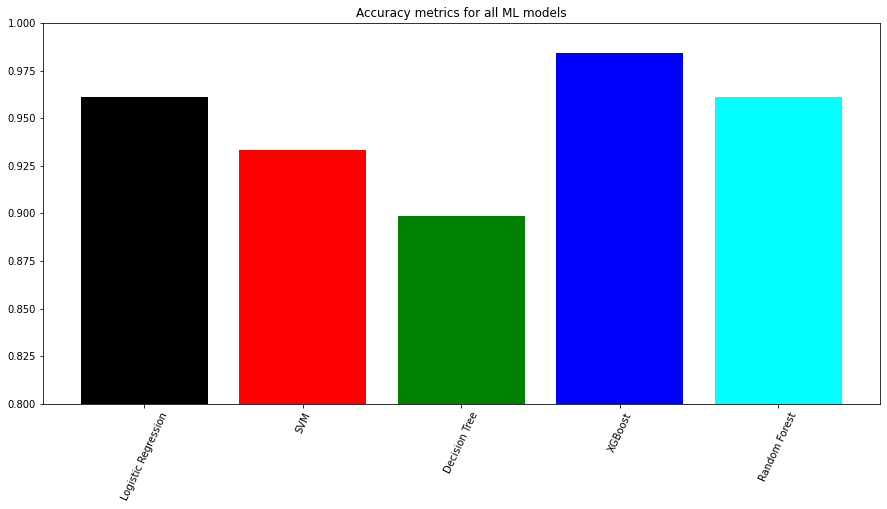

In [81]:
# Creating a bar plot with the accuracy metrics for each model
f, ax = plt.subplots(figsize=(15, 7))
ax.bar(range(len(accuracy_metrics)), accuracy_metrics.values(), color=['black', 'red', 'green', 'blue', 'cyan'])

# Changing the x ticks to model names
ax.set_xticks(range(len(accuracy_metrics)))
ax.set_xticklabels(accuracy_metrics.keys(), rotation=65)

# Adding the title
ax.set_title('Accuracy metrics for all ML models')

# Change y values range
ax.set_ylim([0.8, 1]);

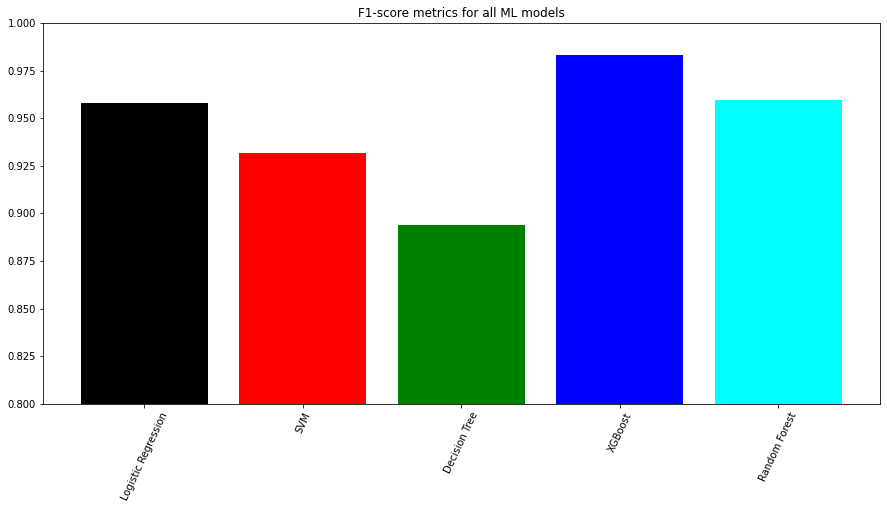

In [83]:
# Creating a bar plot with the f1-score metrics for each model
f, ax = plt.subplots(figsize=(15, 7))
ax.bar(range(len(f1_score_metrics)), f1_score_metrics.values(), color=['black', 'red', 'green', 'blue', 'cyan'])

# Changing the x ticks to model names
ax.set_xticks(range(len(f1_score_metrics)))
ax.set_xticklabels(f1_score_metrics.keys(), rotation=65)

# Adding the title
ax.set_title('F1-score metrics for all ML models')

# Change y values range
ax.set_ylim([0.8, 1]);

## Feature reduction
### Using mutual information between features and target
Now we will try to do some feature reduction to decrease the size of feature space. We will try the technique that is described [here](https://scikit-learn.org/stable/modules/feature_selection.html).

We will use the **mutual information** to select top features which have highest predictive power with the target. Alternatively, we could have used **ANOVA test** as described in the tutorial, to do that switch from `mutual_info_classif` to `f_classif`.

In [84]:
# Defining the function to optimize and number of features to keep
_N_KEEP = 100
_TOP_N = 10
_FEATURE_FUNC_METRICS = mutual_info_classif  # f_classif

# Fitting the selection module
select_top = SelectKBest(_FEATURE_FUNC_METRICS, k=_N_KEEP)
select_top.fit(X_train, y_train)

# Selecting only top _N_KEEP features
X_train_new = select_top.transform(X_train)
X_test_new = select_top.transform(X_test)

# Printing the top _TOP_N features and its corresponding scores
feature_scores = pd.Series(select_top.scores_, index=data_df.columns).sort_values(ascending=False)
print(f'The top {_TOP_N} features according to "{_FEATURE_FUNC_METRICS.__name__}" score:')
display(feature_scores.head(_TOP_N))

The top 10 features according to "mutual_info_classif" score:


LEF1-AS1       0.695053
LINC00266-1    0.665937
LINC00623      0.652616
RARA-AS1       0.648669
PHF1           0.643962
XIST           0.636489
LINC00528      0.621778
PRKCQ-AS1      0.619011
TP53TG1        0.607467
LINC00926      0.593084
dtype: float64

Now let us retrain the models and visualize the performance.

In [86]:
verbose = False
_MODELS = [
    (LogisticRegression(random_state=_SEED, multi_class='multinomial'), 'Logistic Regression'), 
    (DecisionTreeClassifier(random_state=_SEED), 'Decision Tree'), 
    (SVC(random_state=_SEED), 'SVM, RBF'),
    (xgb.XGBClassifier(objective="multi:softmax", random_state=_SEED), 'XGBoost'),
    (RandomForestClassifier(random_state=_SEED), 'Random Forest')
]

accuracy_metrics, f1_score_metrics = {}, {}

for model, model_name in _MODELS:
    
    # Training the model
    fit_model = model.fit(X_train_new, y_train)
    
    # Computing predictions and evaluating the model
    y_train_pred = fit_model.predict(X_train_new)
    y_test_pred = fit_model.predict(X_test_new)

    accuracy_metrics[model_name] = accuracy_score(y_test, y_test_pred)
    f1_score_metrics[model_name] = f1_score(y_test, y_test_pred, average='macro')
    
    # Printing logs
    if verbose:
        print(f'Fitted {model_name} model, classification reports')
        print('Train:')
        print(classification_report(y_train, y_train_pred))
        print('\nTest:')
        print(classification_report(y_test, y_test_pred))

[08:38:54] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


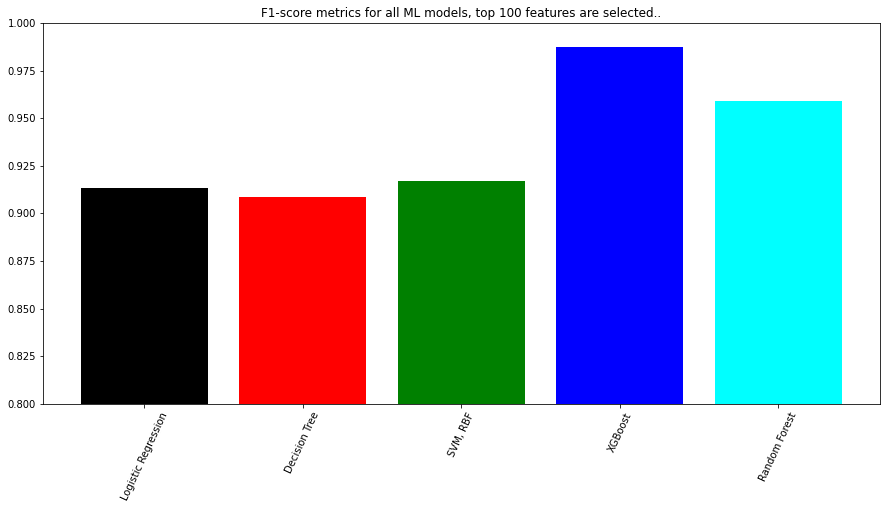

In [88]:
# Creating a bar plot with the f1-score metrics for each model
f, ax = plt.subplots(figsize=(15, 7))
ax.bar(range(len(f1_score_metrics)), f1_score_metrics.values(), color=['black', 'red', 'green', 'blue', 'cyan'])

# Changing the x ticks to model names
ax.set_xticks(range(len(f1_score_metrics)))
ax.set_xticklabels(f1_score_metrics.keys(), rotation=65)

# Adding the title
ax.set_title(f'F1-score metrics for all ML models, top {_N_KEEP} features are selected..')

# Change y values range
ax.set_ylim([0.8, 1]);

### Using PCA to reduce dimensionality
Now we will try to run PCA algorithm on the input feature space and reduce its dimensionality to predefined size.

For PC1 (score=26.39%)
Top positive:
PART1, ZNF503-AS2, FLJ40288, LINC00226, LINC01016
Top negative:
LINC00621, TAPT1-AS1, THAP9-AS1, NNT-AS1, EPB41L4A-AS1

For PC2 (score=12.05%)
Top positive:
DLEU2, LINC00266-1, MIR646HG, SDCBP2-AS1, ITPK1-AS1
Top negative:
FENDRR, LINC01013, BOLA3-AS1, LINC01089, FOXD3-AS1

For PC3 (score=5.72%)
Top positive:
MDS2, LINC00663, HCG18, PCED1B-AS1, PRKCQ-AS1
Top negative:
LPP-AS2, LINC01270, APTR, RARA-AS1, WDFY3-AS2

For PC4 (score=4.28%)
Top positive:
RAB11B-AS1, SPAG5-AS1, WWTR1-AS1, SNAI3-AS1, CAPN15
Top negative:
NEGR1-IT1, COLCA1, SLC2A1-AS1, DHRS4-AS1, LINC00629

For PC5 (score=3.35%)
Top positive:
TTC28-AS1, LINC00408, LINC00622, HCG27, LINC01192
Top negative:
BGLT3, SND1-IT1, GHRLOS, RRN3P2, PCED1B-AS1



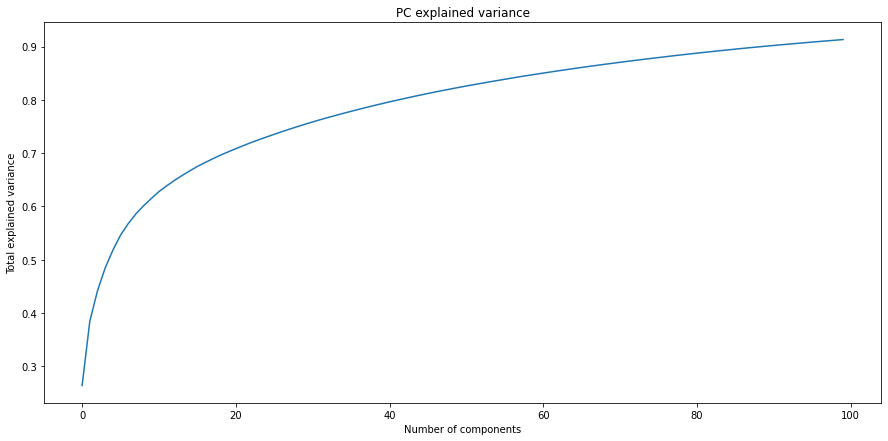

In [89]:
# Defining number of features to keep for downstream model fitting
_N_KEEP = 100
_TOP_N = 5

# Fitting PCA
pca = PCA(n_components=_N_KEEP)
pca.fit(X_train)

# Transforming the data
X_train_new = pca.transform(X_train)
X_test_new = pca.transform(X_test)

# Plotting the explained variance by using top PCs
f, ax = plt.subplots(figsize=(15, 7))
ax.plot(np.cumsum(pca.explained_variance_ratio_))
ax.set_xlabel('Number of components')
ax.set_ylabel('Total explained variance')
ax.set_title('PC explained variance')

# Showing the contribution of each feature to the PCs
pc_components = pd.DataFrame(pca.components_, columns=data_df.columns, index = ['PC{}'.format(i) for i in range(1, len(pca.components_) + 1)])
for ((index, pc_component), explained_variance_ratio) in zip(pc_components.iterrows(), pca.explained_variance_ratio_):
    if index == f'PC{_TOP_N + 1}':
        break
    row_sorted = pc_component.sort_values(ascending=False)
    print(f'For {index} (score={explained_variance_ratio*100:.2f}%)\n'
          f"Top positive:\n{', '.join(row_sorted[:_TOP_N].index)}\n"
          f"Top negative:\n{', '.join(row_sorted[-_TOP_N:].index)}\n")

Firstly, we can see that first 100 principal components explain more than 80 % of the variance in the data (look at the graph above) and, thus, it is a good number of PCs to keep. Secondly, by looking at top PCs (according to scores in `pc.components_`) we can see the contribution of each individual feature to the resulting PCs.

Now we are ready again to train the models and evaluate their performance.

In [93]:
verbose = False
_MODELS = [
    (LogisticRegression(random_state=_SEED, multi_class='multinomial'), 'Logistic Regression'), 
    (DecisionTreeClassifier(random_state=_SEED), 'Decision Tree'), 
    (SVC(random_state=_SEED), 'SVM, RBF'),
    (xgb.XGBClassifier(objective="multi:softmax", random_state=_SEED), 'XGBoost'),
    (RandomForestClassifier(random_state=_SEED), 'Random Forest')
]

accuracy_metrics, f1_score_metrics = {}, {}

for model, model_name in _MODELS:
    
    # Training the model
    fit_model = model.fit(X_train_new, y_train)
    
    # Computing predictions and evaluating the model
    y_train_pred = fit_model.predict(X_train_new)
    y_test_pred = fit_model.predict(X_test_new)

    accuracy_metrics[model_name] = accuracy_score(y_test, y_test_pred)
    f1_score_metrics[model_name] = f1_score(y_test, y_test_pred, average='macro')
    
    # Printing logs
    if verbose:
        print(f'Fitted {model_name} model, classification reports')
        print('Train:')
        print(classification_report(y_train, y_train_pred))
        print('\nTest:')
        print(classification_report(y_test, y_test_pred))

[08:40:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


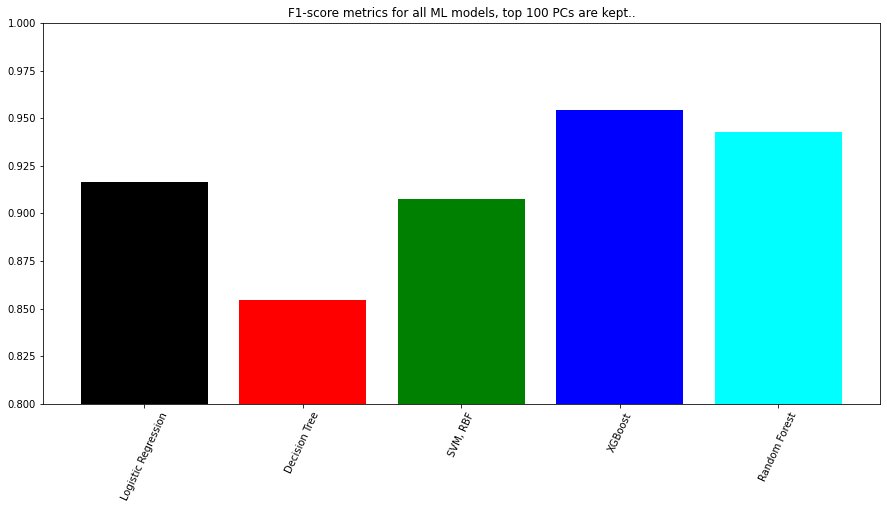

In [94]:
# Creating a bar plot with the f1-score metrics for each model
f, ax = plt.subplots(figsize=(15, 7))
ax.bar(range(len(f1_score_metrics)), f1_score_metrics.values(), color=['black', 'red', 'green', 'blue', 'cyan'])

# Changing the x ticks to model names
ax.set_xticks(range(len(f1_score_metrics)))
ax.set_xticklabels(f1_score_metrics.keys(), rotation=65)

# Adding the title
ax.set_title(f'F1-score metrics for all ML models, top {_N_KEEP} PCs are kept..')

# Change y values range
ax.set_ylim([0.8, 1]);

We can see that the second method using PCA is a little bit **worse** than the first one. 

### Enrichment analysis

Now we will run the enrichment analysis to link the genes that we found to be important in distinguishing sepsis/non-sepsis patients with the cellular processes/molecular functions. To do that, we will use the [ORA algorithm](https://metacpan.org/dist/GO-TermFinder) published by [Boyle et al. 2004](https://doi.org/10.1093/bioinformatics/bth456) and [GSEA algorithm](https://www.gsea-msigdb.org/gsea/index.jsp) published by [Subramanian et al. 2005](https://www.pnas.org/doi/10.1073/pnas.0506580102). To streamline the identificaion of key processes (based on passes genes) we will use the [clusterProfiler](https://bioconductor.org/packages/release/bioc/html/clusterProfiler.html) package which is ""*A universal enrichment tool for interpreting omics data*"". Look for user guide vignette for `clusterProfiler` [here](https://yulab-smu.top/biomedical-knowledge-mining-book/index.html). To read more about the algorithms please look [here](https://yulab-smu.top/biomedical-knowledge-mining-book/enrichment-overview.html), and [here](https://hbctraining.github.io/DGE_workshop_salmon_online/lessons/10_FA_over-representation_analysis.html)

To run ORA and GSEA or other types of enrichment algorithms, we need R. For convenience, we will use the package [rpy2](https://rpy2.github.io) which a bridge between python and R. A special advantage of rpy2 is that it allows to run R code in jupyter notebook with python kernel. For example, you just need to add `%%R` at the top of a cell - then rpy2 will interpret this cell as R cell, and run R code inside.

Ok, now let us load all the packages needed for enrichment analysis.

In [95]:
%%R

# Quietly loading the packages
suppressPackageStartupMessages({
    library(clusterProfiler)
    library(AnnotationHub)
    library(org.Hs.eg.db)
})

In [99]:
# Defining the function to optimize and number of features to keep
_N_KEEP = 100
_FEATURE_FUNC_METRICS = mutual_info_classif  # f_classif

# Fitting the selection module
select_top = SelectKBest(_FEATURE_FUNC_METRICS, k=_N_KEEP)
select_top.fit(X_train, y_train)

# Selecting only top _N_KEEP features
X_train_new = select_top.transform(X_train)
X_test_new = select_top.transform(X_test)
data_df_new = data_df.iloc[:, select_top.get_support(indices=True)]

# Training logistic regression
log_reg = LogisticRegression(random_state=_SEED, multi_class='multinomial').fit(X_train_new, y_train)

# Computing predictions and evaluating the model
y_train_pred = log_reg.predict(X_train_new)
y_test_pred = log_reg.predict(X_test_new)

print('LOGISTIC REGRESSION')
print('Train:')
print(classification_report(y_train, y_train_pred))
print('\nTest:')
print(classification_report(y_test, y_test_pred))

ranked_genes = pd.Series(log_reg.coef_[0], index=data_df_new.columns).sort_values(ascending=False)

print('Ranked list of genes:')
ranked_genes

LOGISTIC REGRESSION
Train:
              precision    recall  f1-score   support

           C       0.99      1.00      1.00       459
          H0       0.90      0.83      0.86       467
         H24       0.88      0.97      0.92       450
         H48       0.86      0.83      0.84       460
      PS_H24       1.00      1.00      1.00       463

    accuracy                           0.93      2299
   macro avg       0.93      0.93      0.92      2299
weighted avg       0.93      0.93      0.92      2299


Test:
              precision    recall  f1-score   support

           C       0.96      1.00      0.98        52
          H0       0.88      0.80      0.83        44
         H24       0.87      1.00      0.93        61
         H48       0.89      0.76      0.82        51
      PS_H24       1.00      1.00      1.00        48

    accuracy                           0.92       256
   macro avg       0.92      0.91      0.91       256
weighted avg       0.92      0.92      0.92

COLCA1       1.718427
CABIN1       1.656733
GLIDR        1.020424
MDS2         0.929887
PHF1         0.879817
               ...   
LINC01352   -0.874664
LINC00324   -0.921525
TTN-AS1     -1.123624
LINC01186   -1.166040
RAMP2-AS1   -1.187715
Length: 100, dtype: float64

Now let us prepare everything for the enrichment analysis. First you need a database that links gene symbols/gene IDs with the molecular processes/functions. The `AnnotationHub` package stores all this information and allows users to easily use genomic databases based on your needs. We are interested only in the human annotation, so we will load a separate package called `org.Hs.eg.db` which focuses only on Homo Sapiens.

We will follow the tutorial provided [here](https://yulab-smu.top/biomedical-knowledge-mining-book/clusterprofiler-go.html). Here we will load the GO annotations from the internet and then use them in our GSE analysis. [Gene ontology (GO)](http://geneontology.org) is the consortium that stores and maintains functional gene annotations for a wide range of species. GO has 3 types of categories:

* Molecular Function or MF - molecular activities of gene products (e.g.  “ligand”, “GTPase”, and “transporter”)
* Cellular Component or CC - locations of gene products (e.g. “nucleus”, “lysosome”, or “plasma membrane”)
* Biological Process or BP - pathways and larger processes made up of the activities of multiple gene products (e.g. “transcription”, “signal transduction”, or “apoptosis”)

First, we need to transfer ranked list of genes from python namespace to R namespace, to do that we will use [ipython magic](https://rpy2.github.io/doc/latest/html/interactive.html).

In [100]:
%%R -i ranked_genes

# Taking a look at R variable `ranked_genes`
head(ranked_genes)

   COLCA1    CABIN1     GLIDR      MDS2      PHF1  HOXB-AS1 
1.7184273 1.6567335 1.0204242 0.9298873 0.8798171 0.8591971 


As you can see the rpy2 transferred python `ranked_genes` to R `ranked_genes`. The next step will be to obtain ENTREZ ID signatures for each gene name which is a requirement for `clusterProfiler`. To do that we will use `bitr` function.

In [101]:
%%R

# Obtaining ENTREZ ID and ENSEMBL ID signatures for the gene symbols
gene_anno <- bitr(names(ranked_genes), fromType = "SYMBOL",
                  toType = c('ENTREZID'),
                  OrgDb = org.Hs.eg.db)

# Getting a copy of ranked list of genes, where we will stored ENTREZ ID
entrez_ranked_genes <- ranked_genes
names(entrez_ranked_genes) <- gene_anno$ENTREZID

cat('The corresponding ENTREZ IDs and ENSEMBL IDs:\n')
head(gene_anno)

R[write to console]: 'select()' returned 1:1 mapping between keys and columns



The corresponding ENTREZ IDs and ENSEMBL IDs:
    SYMBOL  ENTREZID
1   COLCA1    399948
2   CABIN1     23523
3    GLIDR    389741
4     MDS2    259283
5     PHF1      5252
6 HOXB-AS1 100874362


### Over-representation analysis (ORA)

We will first try ORA algorithm to find enriched molecular functions/cellular processes. We need to provide gene markers for that algorithms (e.g. DE genes). We will use first 10 genes and the head and the tail of the ranked list (max and min coefficient values). Background genes (genes that are considered to be non-significant in group comparison) will be the rest of the genes.

In [102]:
### This is a python cell - obtaining list of background genes

# Getting all gene names
all_genes =  data_df.columns

# Transferring all gene names to R namespace
%R -i all_genes

# Matching gene names with ENTREZ ID
%R all_gene_anno <- bitr(all_genes, fromType = "SYMBOL", \
                     toType = c('ENTREZID'), \
                     OrgDb = org.Hs.eg.db)

# Printing the head of annotation
%R head(all_gene_anno)

R[write to console]: 'select()' returned 1:1 mapping between keys and columns



,SYMBOL,ENTREZID
1,A2M-AS1,144571
2,ADAMTS9-AS2,100507098
3,ADD3-AS1,100505933
4,ADIRF-AS1,100133190
5,ADORA2A-AS1,646023
6,AFAP1-AS1,84740


In [106]:
%%R

# Getting the list of significant genes (top-5 in the head + top-5 in the tail)
significant_genes <- c(head(names(entrez_ranked_genes), 20), tail(names(entrez_ranked_genes), 20))

ego <- enrichGO(gene          = significant_genes,
                OrgDb         = org.Hs.eg.db,
                universe      = all_gene_anno$ENTREZID,
                ont           = "BP",  # biological process
                pAdjustMethod = "BH",
                pvalueCutoff  = 1,  # getting everything
                qvalueCutoff  = 1,  # getting everything
                readable      = TRUE)
head(ego)

                   ID                                            Description
GO:0010605 GO:0010605 negative regulation of macromolecule metabolic process
GO:0044260 GO:0044260               cellular macromolecule metabolic process
GO:1901564 GO:1901564              organonitrogen compound metabolic process
GO:0009987 GO:0009987                                       cellular process
GO:0009892 GO:0009892               negative regulation of metabolic process
GO:0051716 GO:0051716                          cellular response to stimulus
           GeneRatio BgRatio     pvalue  p.adjust    qvalue
GO:0010605       5/7   10/29 0.03024257 0.1881059 0.1675438
GO:0044260       5/7   10/29 0.03024257 0.1881059 0.1675438
GO:1901564       5/7   10/29 0.03024257 0.1881059 0.1675438
GO:0009987       7/7   20/29 0.04966747 0.1881059 0.1675438
GO:0009892       5/7   11/29 0.05082843 0.1881059 0.1675438
GO:0051716       5/7   11/29 0.05082843 0.1881059 0.1675438
                                         

We can see that we obtain results with low significance which may indicate either:

* low level of annotation for lncRNAs
* enrichment analysis is usually done on all genes, here we pass only lncRNAs

#### Gene set enrichment analysis

Now we will try to run GSEA on the same dataset.

In [107]:
%%R

gse <- gseGO(geneList     = entrez_ranked_genes,
             OrgDb        = org.Hs.eg.db,
             ont          = "BP",
             minGSSize    = 100,
             maxGSSize    = 500,
             pvalueCutoff = 1,
             verbose      = FALSE)

gse

R[write to console]: no term enriched under specific pvalueCutoff...



#
# Gene Set Enrichment Analysis
#
#...@organism 	 Homo sapiens 
#...@setType 	 BP 
#...@keytype 	 ENTREZID 
#...@geneList 	 Named num [1:100] 1.72 1.66 1.02 0.93 0.88 ...
 - attr(*, "names")= chr [1:100] "399948" "23523" "389741" "259283" ...
#...nPerm 	 
#...pvalues adjusted by 'BH' with cutoff <1 
#...0 enriched terms found
'data.frame':	0 obs. of  8 variables:
 $ ID             : chr 
 $ Description    : chr 
 $ setSize        : int 
 $ enrichmentScore: num 
 $ NES            : num 
 $ pvalue         : num 
 $ p.adjust       : num 
 $ qvalues        : num 
#...Citation
  Guangchuang Yu, Li-Gen Wang, Yanyan Han and Qing-Yu He.
  clusterProfiler: an R package for comparing biological themes among
  gene clusters. OMICS: A Journal of Integrative Biology
  2012, 16(5):284-287 



We can see that no enrichment terms are found. The reasons could be the same.

Voilà!